# In the beginning... there were imports and global parameters

In [1]:
from jax import numpy as jnp, random, vmap, value_and_grad
from jax.lax import scan
import networkx
import matplotlib.pyplot as plt
import optax

import qujax

In [2]:
n_nodes = 6
degree = 3
n_qubits = n_nodes - 1
circuit_depth = 2
init_rad = 0.001 / jnp.pi
stepsize = 1e-3
n_steps = 1000
random_key = random.PRNGKey(0)

In [3]:
graph_key, weights_key, init_key = random.split(random_key, 3)

# Then came the problem specification

In this case the maximal cutting a degree three, regular graph with six nodes and randomly weighted edges. Note that this corresponds to a five qubit maxcut problem since the first node can be labelled as zero by default.

Recall that a maxcut problem is the problem of finding the _binary labelling of nodes such that the sum of edge weights for edges with differing nodes_ is maximised.

In [4]:
nx_graph = networkx.generators.random_graphs.random_regular_graph(degree, n_nodes, seed=int(graph_key[-1]))
edge_inds = jnp.array(nx_graph.edges)
weights = random.uniform(weights_key, shape=(len(edge_inds),))

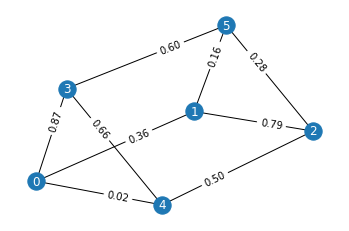

In [5]:
pos = networkx.spring_layout(nx_graph)
networkx.draw_networkx_nodes(nx_graph, pos)
networkx.draw_networkx_labels(nx_graph, pos, font_color='white')
networkx.draw_networkx_edges(nx_graph, pos)
networkx.draw_networkx_edge_labels(nx_graph, pos, label_pos=0.35,
                                   edge_labels={tuple(e):f'{w:.2f}' for e, w in zip(edge_inds.tolist(), weights)})
plt.axis('off');

The cost function can then be defined directly on a bitstring

In [6]:
def cost_of_bitstring(z):
    z = jnp.append(0, z)

    def get_z_edge_weight(ei, w):
        i, j = ei
        return jnp.where(z[i] != z[j], w, 0.)

    return -vmap(get_z_edge_weight)(edge_inds, weights).sum()

# Then comes the quantum circuit

The quantum circuit is comprised of a series of gates, some of which are entangling, some of which are parameterised...

In [7]:
def get_circuit(n_qubits, depth):
    
    n_params = 2 * n_qubits * (depth + 1)
    
    
    gates = ['H'] * n_qubits + ['Rx'] * n_qubits + ['Rz'] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]
    
    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append('CZ')
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append('Rx')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append('Ry')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

In [8]:
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)

In [9]:
print(gates)
print(len(gates))

['H', 'H', 'H', 'H', 'H', 'Rx', 'Rx', 'Rx', 'Rx', 'Rx', 'Rz', 'Rz', 'Rz', 'Rz', 'Rz', 'CZ', 'CZ', 'CZ', 'CZ', 'Rx', 'Rx', 'Rx', 'Rx', 'Rx', 'Ry', 'Ry', 'Ry', 'Ry', 'Ry', 'CZ', 'CZ', 'CZ', 'CZ', 'Rx', 'Rx', 'Rx', 'Rx', 'Rx', 'Ry', 'Ry', 'Ry', 'Ry', 'Ry']
43


In [10]:
print(qubit_inds)
print(len(qubit_inds))

[[0], [1], [2], [3], [4], [0], [1], [2], [3], [4], [0], [1], [2], [3], [4], [0, 1], [1, 2], [2, 3], [3, 4], [0], [1], [2], [3], [4], [0], [1], [2], [3], [4], [0, 1], [1, 2], [2, 3], [3, 4], [0], [1], [2], [3], [4], [0], [1], [2], [3], [4]]
43


In [11]:
print(param_inds)
print(len(param_inds))

[[], [], [], [], [], [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [], [], [], [], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [], [], [], [], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
43


Passes the eye test 👍

# Now to invoke qujax

Let's generate the parameters -> statetensor function.

Always be aware that we still have convention where parameters are specified as multiples of $\pi$ - that is in [0,2].

In [12]:
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)

And then convert it into a parameters -> maxcut cost function

In [13]:
def param_to_cost(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    bitstrings = qujax.integers_to_bitstrings(jnp.arange(st.size), st.ndim)
    return (vmap(cost_of_bitstring)(bitstrings) * probs).sum()

We now our cost function, we can use JAX to generate gradients and then we are ready to train with gradient descent

# Gradient descent time

We will use [optax](https://github.com/deepmind/optax) to run gradient descent with Adam

In [14]:
param_to_cost_and_grad = value_and_grad(param_to_cost)

In [15]:
optimiser = optax.adam(stepsize)

In [16]:
init_param = random.uniform(init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad)

In [17]:
init_opt_state = optimiser.init(init_param)

In [18]:
def gd_iteration(params_and_opt_state, step):
    params, opt_state = params_and_opt_state

    cost, grads = param_to_cost_and_grad(params)

    updates, new_opt_state = optimiser.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return (new_params, new_opt_state), (params, cost)

In [19]:
_, (params_path, cost_path) = scan(gd_iteration,
                                   (init_param, init_opt_state),
                                   jnp.arange(n_steps))

Lets visualise the results

In [20]:
opt_cost = vmap(cost_of_bitstring)(qujax.integers_to_bitstrings(jnp.arange(2 ** n_qubits), n_qubits)).min()

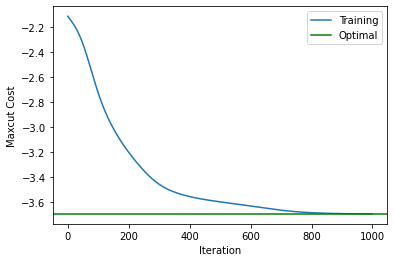

In [21]:
plt.plot(cost_path, label='Training')
plt.axhline(opt_cost, color='green', label='Optimal')
plt.xlabel('Iteration')
plt.ylabel('Maxcut Cost')
plt.legend();